<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
# import wget
import zipfile
import os

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
!gsutil cp gs://{bucket_name}/model_21.pt ./model_2.pt 

Copying gs://pneumonia/model_21.pt...
| [1 files][383.0 MiB/383.0 MiB]                                                
Operation completed over 1 objects/383.0 MiB.                                    


In [0]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

Copying gs://pneumonia/celeba-dataset.zip...
| [1 files][  1.2 GiB/  1.2 GiB]  104.4 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [0]:
if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()
  
# if not os.path.exists("GWB_200x200_JPEG.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
#   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()  

--2019-05-09 05:28:29--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.5
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073596 (1.0M) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>]   1.02M  --.-KB/s    in 0.09s   

2019-05-09 05:28:30 (11.6 MB/s) - ‘Training_Pictures.zip’ saved [1073596/1073596]



In [0]:
if not os.path.exists("wiki_images2.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
  zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()
  
if not os.path.exists("imdb_images3.zip"):
  !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
  zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()    

Copying gs://pneumonia/wiki_images2.zip...
\ [1 files][160.5 MiB/160.5 MiB]                                                
Operation completed over 1 objects/160.5 MiB.                                    
Copying gs://pneumonia/imdb_images3.zip...
- [1 files][  1.5 GiB/  1.5 GiB]  105.0 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [0]:
BATCH_SIZE = 48
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=False, fillcolor=0),        
      ], 0.4),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

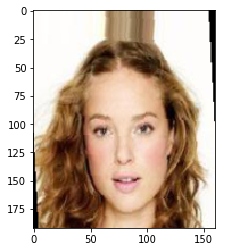

In [0]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 393640
    Root Location: data/images
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomApply(
                             p=0.4
                             RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05), scale=(0.9, 1.1), shear=(-2, 2))
                         )
                             RandomResizedCrop(size=(192, 160), scale=(0.9, 1.1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

### Bigger Model

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, mu=None, logvar=None):
    MSE = nn.functional.mse_loss(x, x_hat)
    
    if mu is not None and logvar is not None:
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      KLD /= BATCH_SIZE * 784
      MSE = MSE + KLD
      
    return MSE
  
def train(model, train_loader, optimizer, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_2.pt"):
    model.train()
    try:
      for epoch in range(num_epochs):
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_loss = 0.0
          batch_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss = vae_loss(inputs, recon, code, logvar=logvar)
              else:  
                  loss = vae_loss(inputs, recon, code, logvar=None)

              loss.backward()
              optimizer.step()

              tr_loss += loss.item()
              batch_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", loss.item())

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()

          print("Epoch:", len(epoch_list), "Loss:", tr_loss)
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

          if epoch % display_images == 0:
              # plot a few random images
              try:
                  fig, ax = plt.subplots(1, 2, figsize=(6,6))
                  ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                  ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                  plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
    
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params                

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.downsize1 = nn.Conv2d(96, 64, 1)
        
        # block 2
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.downsize2 = nn.Conv2d(192, 128, 1)
        
        # block 3
        self.conv7 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.downsize3 = nn.Conv2d(384, 256, 1)
        
        # block 4
        self.conv10 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.downsize4 = nn.Conv2d(512, 384, 1)
        
        # block 5
        self.conv12 = nn.Conv2d(384, 384, 3, padding=1)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        
        self.fc1 = nn.Conv2d(384, latent_dim, (6,5)) # code layer

        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.variational = variational
        
    def encode(self, x):
        # input 178x178x3 - output 80x80x32
        h1 = self.relu(self.conv1(x))
        h2 = self.relu(self.conv2(h1))
        h3 = self.relu(self.conv3(h2))
        ds1 = self.relu(self.downsize1(torch.cat((h1,h2,h3), 1)))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x40x40
        h4 = self.conv4(mp1)
        h5 = self.relu(self.conv5(self.relu(h4)))
        h6 = self.relu(self.conv6(h5))
        ds2 = self.relu(self.downsize2(torch.cat((h4,h5,h6), 1)))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x20x20
        h7 = self.conv7(mp2)
        h8 = self.relu(self.conv8(self.relu(h7)))
        h9 = self.relu(self.conv9(h8))
        ds3 = self.relu(self.downsize3(torch.cat((h7,h8,h9), 1)))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x10x10
        h10 = self.relu(self.conv10(mp3))
        h11 = self.relu(self.conv11(h10))
        ds4 = self.relu(self.downsize4(torch.cat((h10,h11), 1)))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x5x5
        h12 = self.relu(self.conv12(mp4))
        h13 = self.relu(self.conv13(h12))
        ds5 = self.relu(self.downsize5(torch.cat((h12,h13), 1)))
        mp5 = self.max_pool(ds5)
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(mp5)
        logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 384, (6,5), stride=1)
        self.deconv1 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.deconv4 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.deconv5 = nn.ConvTranspose2d(192, 156, 2, stride=2, output_padding=0)
        self.deconv6 = nn.ConvTranspose2d(156, 128, 2, stride=2, output_padding=0)
#         self.deconv7 = nn.ConvTranspose2d(128, 64, 2, stride=1)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.fc1(x))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.deconv1(h0))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.deconv3(h1))
        h4 = self.relu(self.deconv4(h3))
        h5 = self.relu(self.deconv5(h4))
        h6 = self.relu(self.deconv6(h5))
#         h7 = self.relu(self.deconv7(h6, output_size=(160,160)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar

In [0]:
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
model = SingleModel(encoder, decoder)
params = model.parameters()

print("Total Params:", count_params(model))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    model.cuda()
    
optimizer = optim.Adam(params, lr=0.0009)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

try:
  model.load_state_dict(torch.load("model_2.pt"))
  print("Model loaded")
except:
  print("Error loading model")
  pass

Total Params: 100401791
Model loaded


Batch: 0 loss: 0.08388300240039825
Batch: 1000 loss: 0.024303049501031636
	Epoch 0 batch 1000 loss: 0.014461498707532883
Batch: 2000 loss: 0.012949811139144004
	Epoch 0 batch 2000 loss: 0.012615836225450039


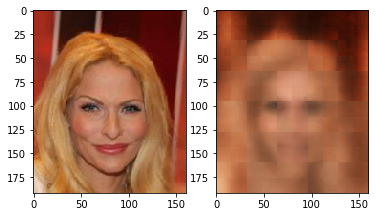

Batch: 3000 loss: 0.010485455363057554
	Epoch 0 batch 3000 loss: 0.010897526517510414
Batch: 4000 loss: 0.009422714732587337
	Epoch 0 batch 4000 loss: 0.010371681302785873


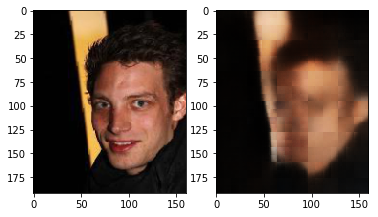

Epoch: 0 Loss: 62.11736378027126


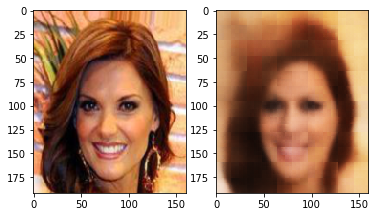

Batch: 0 loss: 0.00887374673038721
Interrupting... Saving model...


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken p

Copying file://model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/383.0 MiB.                                    


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=2000, num_epochs=3, display_images=1, scheduler=scheduler, save_path="model_2.pt")

	Epoch 1 batch 1000 loss: 0.00804841984063387
	Epoch 1 batch 2000 loss: 0.007652648258954287
	Epoch 1 batch 3000 loss: 0.0077958363108336926
	Epoch 1 batch 4000 loss: 0.007254715543240309


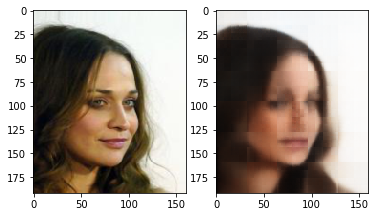

Epoch: 1 Loss: 34.35561678977683


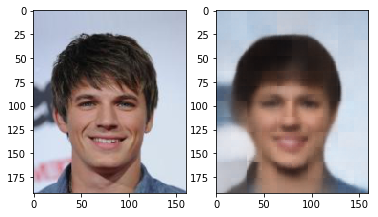

	Epoch 2 batch 1000 loss: 0.005714085418730974
	Epoch 2 batch 2000 loss: 0.006604641675949097
	Epoch 2 batch 3000 loss: 0.006450094748288393
	Epoch 2 batch 4000 loss: 0.0060354191809892654


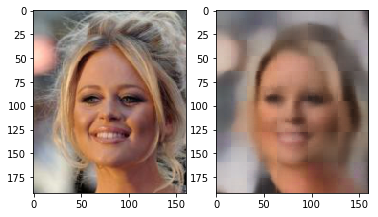

Epoch: 2 Loss: 28.369787100236863


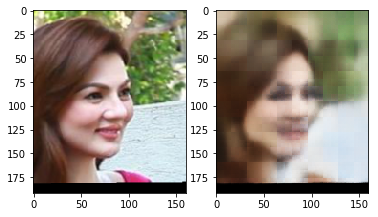

	Epoch 3 batch 1000 loss: 0.005391469690948725
	Epoch 3 batch 2000 loss: 0.005265592131763697
	Epoch 3 batch 3000 loss: 0.004803805612027645
	Epoch 3 batch 4000 loss: 0.0048538632690906525


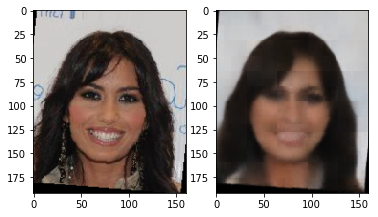

Epoch: 3 Loss: 24.18163928994909


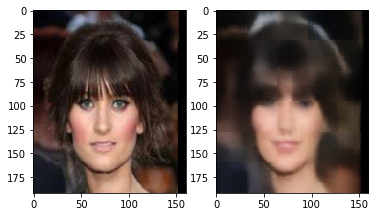

	Epoch 4 batch 1000 loss: 0.004362077917903662


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken p

Interrupting... Saving model...
Copying file://model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/383.0 MiB.                                    


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, num_epochs=5, display_images=1, scheduler=scheduler)

	Epoch 0 batch 1000 loss: 0.0047831120900809765
	Epoch 0 batch 2000 loss: 0.00507998326793313


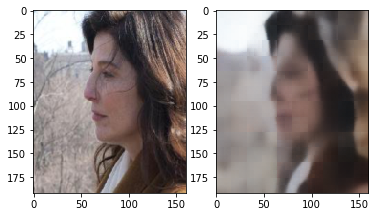

	Epoch 0 batch 3000 loss: 0.004596892278641462
	Epoch 0 batch 4000 loss: 0.004213131032884121


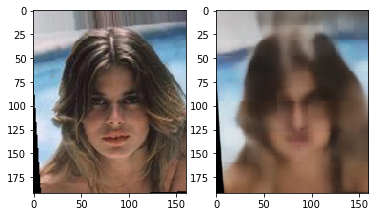

	Epoch 0 batch 5000 loss: 0.004440728574991226
	Epoch 0 batch 6000 loss: 0.00466274656355381


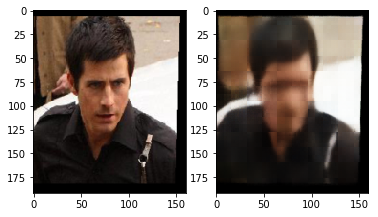

	Epoch 0 batch 7000 loss: 0.004382247570902109
	Epoch 0 batch 8000 loss: 0.004062923137098551


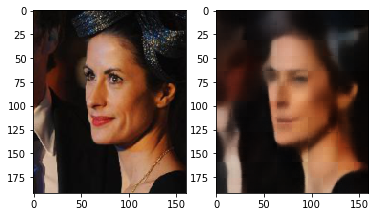

Epoch: 0 Loss: 38.269012982491404


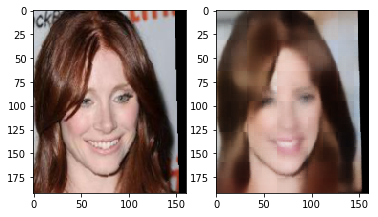

	Epoch 1 batch 1000 loss: 0.004020005464553833
	Epoch 1 batch 2000 loss: 0.004596323240548372


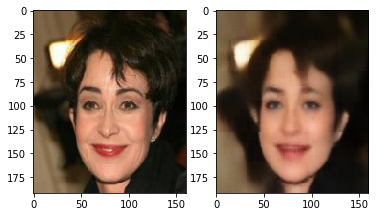

	Epoch 1 batch 3000 loss: 0.003696879604831338
	Epoch 1 batch 4000 loss: 0.004736817441880703


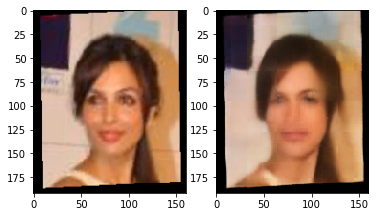

	Epoch 1 batch 5000 loss: 0.0041045621037483215
	Epoch 1 batch 6000 loss: 0.0038135068025439978


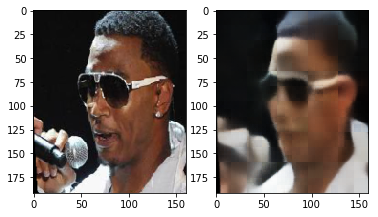

	Epoch 1 batch 7000 loss: 0.003701040055602789
	Epoch 1 batch 8000 loss: 0.004048636183142662


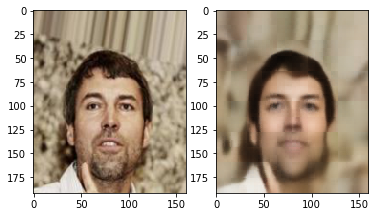

Epoch: 1 Loss: 33.659836436854675


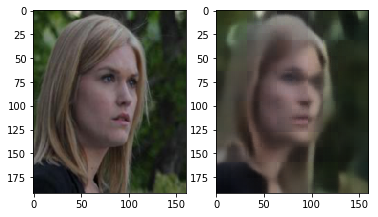

	Epoch 2 batch 1000 loss: 0.0041509936563670635
	Epoch 2 batch 2000 loss: 0.004087257198989391


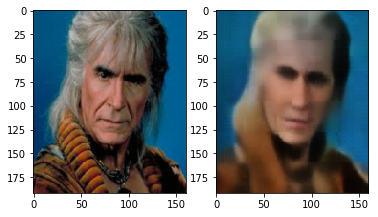

	Epoch 2 batch 3000 loss: 0.0036401546094566584
	Epoch 2 batch 4000 loss: 0.004544345661997795


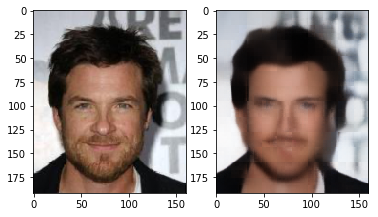

	Epoch 2 batch 5000 loss: 0.003751457901671529
	Epoch 2 batch 6000 loss: 0.0034722359851002693


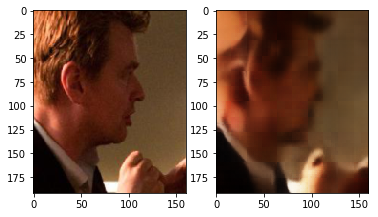

	Epoch 2 batch 7000 loss: 0.003593300934880972
	Epoch 2 batch 8000 loss: 0.003483648644760251


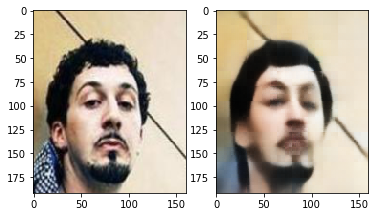

Epoch: 2 Loss: 30.925697496859357


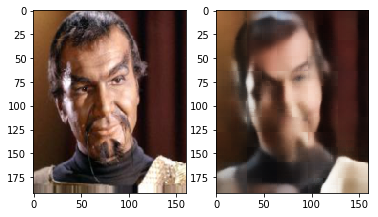

Copying file://model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/383.0 MiB.                                    


In [0]:
train(model, train_loader, optimizer, plot_images=2000, num_epochs=3, display_images=1, scheduler=scheduler)

	Epoch 3 batch 1000 loss: 0.00349734746851027
	Epoch 3 batch 2000 loss: 0.0038349698297679424
	Epoch 3 batch 3000 loss: 0.003377821296453476


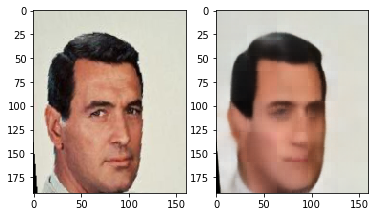

	Epoch 3 batch 4000 loss: 0.0035454067401587963
	Epoch 3 batch 5000 loss: 0.0033108701463788748
	Epoch 3 batch 6000 loss: 0.0036642912309616804


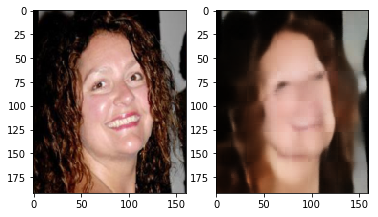

	Epoch 3 batch 7000 loss: 0.003473106538876891
	Epoch 3 batch 8000 loss: 0.003637397661805153
Epoch: 3 Loss: 29.021321073174477


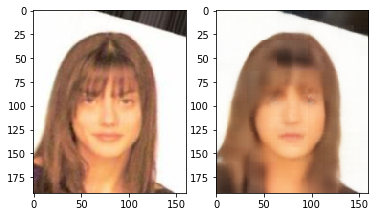

	Epoch 4 batch 1000 loss: 0.00306972349062562
	Epoch 4 batch 2000 loss: 0.004009931813925505
	Epoch 4 batch 3000 loss: 0.003397842636331916


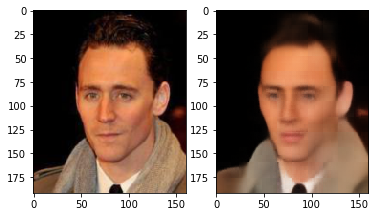

	Epoch 4 batch 4000 loss: 0.0033753165043890476
	Epoch 4 batch 5000 loss: 0.0036123658064752817
	Epoch 4 batch 6000 loss: 0.0031005963683128357


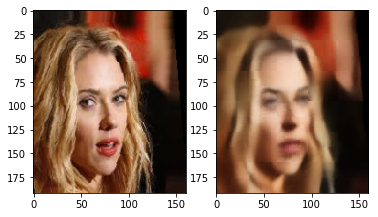

	Epoch 4 batch 7000 loss: 0.0036813507322221994
	Epoch 4 batch 8000 loss: 0.0027121449820697308
Epoch: 4 Loss: 27.535263204248622


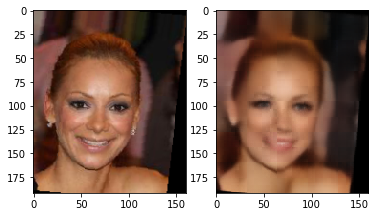

	Epoch 5 batch 1000 loss: 0.0034628885332494974
	Epoch 5 batch 2000 loss: 0.0033736766781657934
	Epoch 5 batch 3000 loss: 0.0031702856067568064


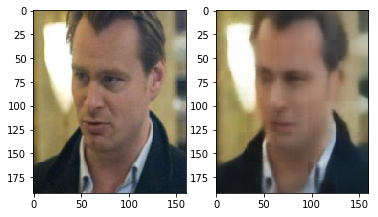

	Epoch 5 batch 4000 loss: 0.003447791328653693
	Epoch 5 batch 5000 loss: 0.003103801980614662
	Epoch 5 batch 6000 loss: 0.0030482022557407618


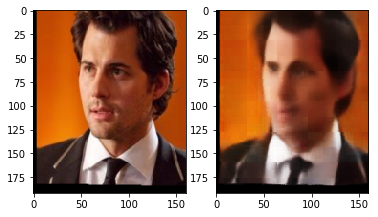

	Epoch 5 batch 7000 loss: 0.0029985536821186543
	Epoch 5 batch 8000 loss: 0.0029440552461892366
Epoch: 5 Loss: 26.377998851938173


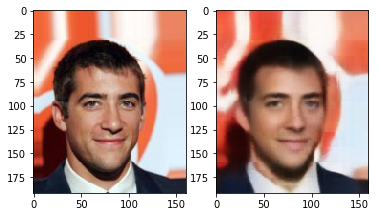

Copying file://model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/383.0 MiB.                                    


In [0]:
train(model, train_loader, optimizer, plot_images=3000, num_epochs=3, display_images=1, scheduler=scheduler)

	Epoch 0 batch 1000 loss: 0.0026650321669876575
	Epoch 0 batch 2000 loss: 0.0030423556454479694
	Epoch 0 batch 3000 loss: 0.002788320416584611
	Epoch 0 batch 4000 loss: 0.003261420875787735


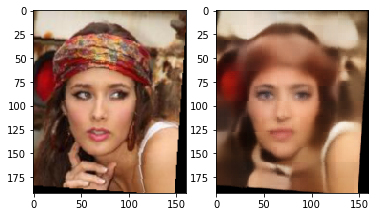

	Epoch 0 batch 5000 loss: 0.0031188169959932566
	Epoch 0 batch 6000 loss: 0.002683007624000311
	Epoch 0 batch 7000 loss: 0.002832101657986641
	Epoch 0 batch 8000 loss: 0.0034462877083569765


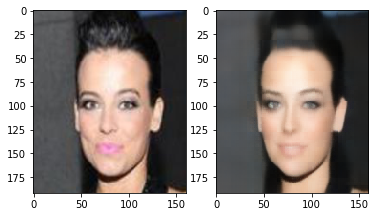

Epoch: 0 Loss: 25.214703206671402


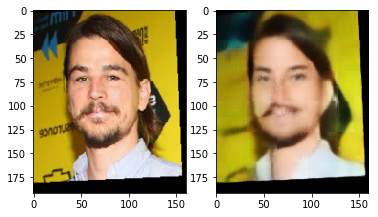

	Epoch 1 batch 1000 loss: 0.002942155348137021
	Epoch 1 batch 2000 loss: 0.003279086435213685
	Epoch 1 batch 3000 loss: 0.0031652110628783703
	Epoch 1 batch 4000 loss: 0.0027589555829763412


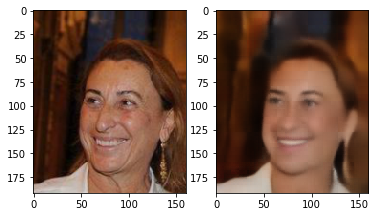

	Epoch 1 batch 5000 loss: 0.0029304376803338528
	Epoch 1 batch 6000 loss: 0.002879286417737603
	Epoch 1 batch 7000 loss: 0.00311908102594316
	Epoch 1 batch 8000 loss: 0.00278267590329051


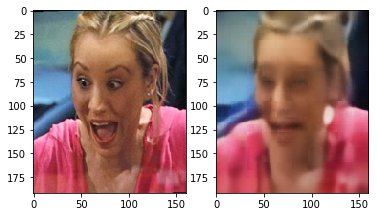

Epoch: 1 Loss: 24.364710872760043


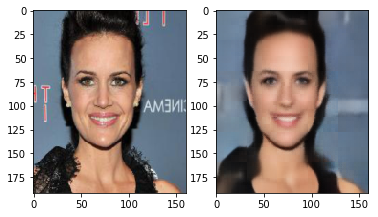

	Epoch 2 batch 1000 loss: 0.0028431143146008253
	Epoch 2 batch 2000 loss: 0.0023565234150737524
	Epoch 2 batch 3000 loss: 0.0026112115010619164
	Epoch 2 batch 4000 loss: 0.002886127447709441


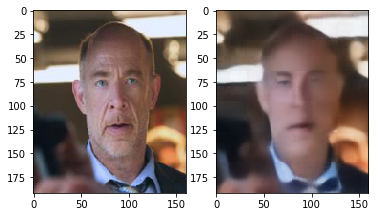

	Epoch 2 batch 5000 loss: 0.002913466887548566
	Epoch 2 batch 6000 loss: 0.0027590191457420588
	Epoch 2 batch 7000 loss: 0.002711446722969413
	Epoch 2 batch 8000 loss: 0.0026946363504976034


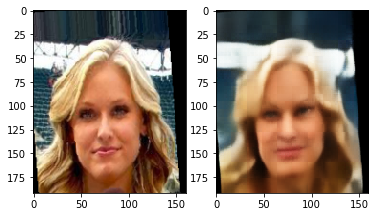

Epoch: 2 Loss: 23.718850914388895


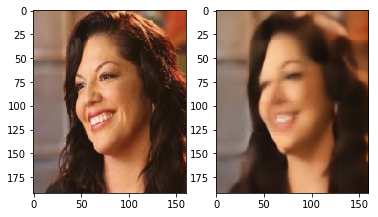

Copying file://model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/383.0 MiB.                                    


In [0]:
train(model, train_loader, optimizer, plot_images=4000, num_epochs=3, display_images=1, scheduler=scheduler)

	Epoch 3 batch 1000 loss: 0.002553920727223158
	Epoch 3 batch 2000 loss: 0.002692219102755189
	Epoch 3 batch 3000 loss: 0.0026647758204489946


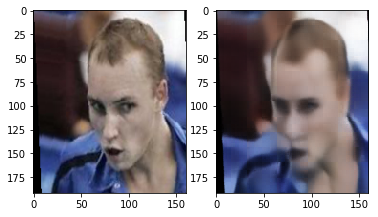

	Epoch 3 batch 4000 loss: 0.0026759253814816475
	Epoch 3 batch 5000 loss: 0.002740158699452877
	Epoch 3 batch 6000 loss: 0.002700171899050474


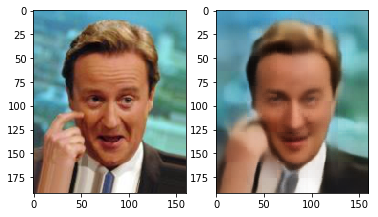

	Epoch 3 batch 7000 loss: 0.0026109979953616858
	Epoch 3 batch 8000 loss: 0.0030725053511559963
Epoch: 3 Loss: 23.162952120881528


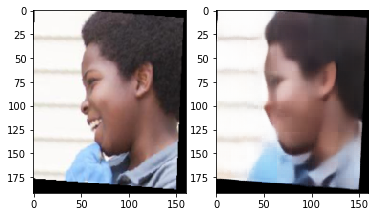

	Epoch 4 batch 1000 loss: 0.0032004734966903925
	Epoch 4 batch 2000 loss: 0.0027859127148985863
	Epoch 4 batch 3000 loss: 0.002667827531695366


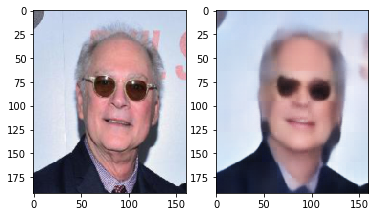

	Epoch 4 batch 4000 loss: 0.002965844003483653
	Epoch 4 batch 5000 loss: 0.003128072014078498
	Epoch 4 batch 6000 loss: 0.0022252099588513374


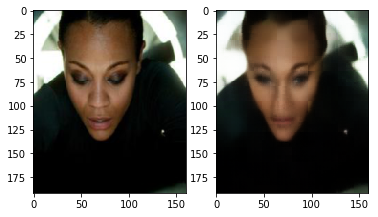

Interrupting... Saving model...


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

Copying file://model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/383.0 MiB.                                    


In [16]:
train(model, train_loader, optimizer, plot_images=3000, num_epochs=3, display_images=1, scheduler=scheduler)

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")